### Imports:

In [38]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.image as mpimg

%matplotlib widget

### Reading Data:

In [122]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)

    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))

    return numpyImage, numpyOrigin, numpySpacing

def read_luna_dataset(root_dir):
    Dataset={}
    subsets = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

    for subset in subsets:
        mhd_files = [f for f in os.listdir(os.path.join(root_dir, subset)) if f.endswith(".mhd")]
        if subset not in Dataset:
            Dataset[subset] = {}

        for index, file in enumerate(mhd_files):
            Dataset[subset][f"CT_{index}"] = file

    return Dataset


In [123]:
if __name__ == "__main__":
    Data = read_luna_dataset("Data")

In [124]:
def load_csv(filename):
    return pd.read_csv(f"Data/{filename}")

In [125]:
def basic_statistics(data):
    print("Infos:\n", data.info())
    print("Description:\n", data.describe())
    print("Presence of null values:\n")
    print(data.isnull().sum())

In [126]:
if __name__ == "__main__":
    annotations = load_csv("annotations.csv")
    basic_statistics(annotations)
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   seriesuid    1186 non-null   object 
 1   coordX       1186 non-null   float64
 2   coordY       1186 non-null   float64
 3   coordZ       1186 non-null   float64
 4   diameter_mm  1186 non-null   float64
dtypes: float64(4), object(1)
memory usage: 46.5+ KB
Infos:
 None
Description:
             coordX       coordY       coordZ  diameter_mm
count  1186.000000  1186.000000  1186.000000  1186.000000
mean     -5.067547     8.428113  -160.159029     8.306527
std      84.468115    98.316003   279.829437     4.762033
min    -164.351031  -283.834336  -790.074799     3.253443
25%     -80.909225   -51.549643  -221.197808     5.107177
50%     -32.855132    18.787926  -167.615160     6.433600
75%      76.830069    67.245915  -109.735281     9.696301
max     164.763985   271.405521  1790.494057    32.27003

In [127]:
def scatter(data):
    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot
    ax.scatter(data["coordX"], data["coordY"], data["coordZ"], c='blue', alpha=0.5)

    # Labels
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_zlabel("Z Coordinate")
    ax.set_title("3D Scatter Plot of Coordinates")

    plt.show()

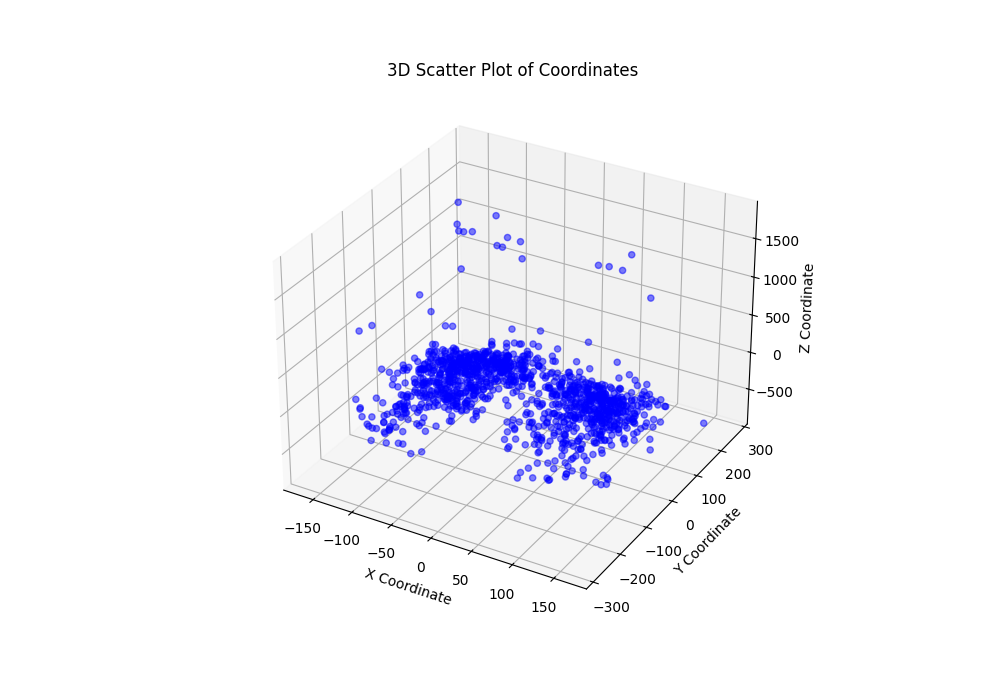

In [129]:
if __name__ == "__main__":
    scatter(annotations)

In [130]:
def diameters_hist(data):
    plt.figure(figsize=(8, 5))
    plt.hist(data["diameter_mm"], bins=30, color="skyblue", edgecolor="black")
    plt.xlabel("Diameter (mm)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Nodule Diameters")
    plt.show()


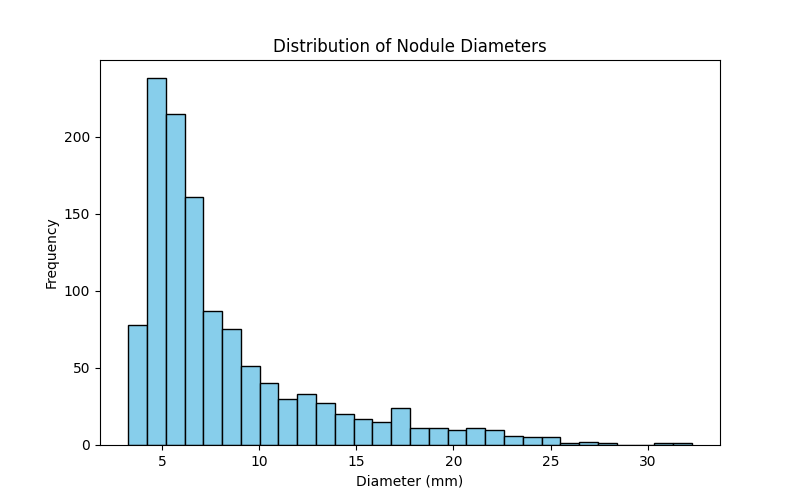

In [131]:
if __name__ == "__main__":
    diameters_hist(annotations)

In [119]:
def visualize_single_slice(ct_scan):
    numpyImage, numpyOrigin, numpySpacing = load_itk_image(os.path.join("Data/subset0", ct_scan))

    # Create figure and adjust layout to make room for slider
    fig, (ax, ax_xray) = plt.subplots(1, 2, figsize=(16, 8))
    plt.subplots_adjust( right=0.8)

    # Initialize slice (middle slice)
    initial_slice = numpyImage.shape[0] // 2
    current_slice = initial_slice

    # Display initial slice (CT scan) on the left side
    im = ax.imshow(numpyImage[initial_slice], cmap="gray")
    ax.set_title(f"CT Scan Slice {initial_slice}")
    ax.axis("off")

    # Load your chest X-ray image
    xray_image_path = "Assets/chest.jpg"  # Replace with your actual chest X-ray image path
    xray_image = mpimg.imread(xray_image_path)
    height, width = xray_image.shape[:2]
    initial_line_h = height // 2 
    slices_nbr = numpyImage.shape[0] - 1
    line_slices = np.linspace(0, height, slices_nbr)

    # Set up X-ray image on the right side
    xray_im = ax_xray.imshow(xray_image, cmap="gray")
    ax_xray.set_title("Chest X-Ray")
    ax_xray.axis("off")
    
    # Add a horizontal line on the X-ray image indicating the current slice
    line = ax_xray.axhline(y=line_slices[current_slice], color="red", linestyle="--", linewidth=2)

    # Create vertical slider on the left side
    ax_slider = plt.axes([0.85, 0.26, 0.03, 0.47])  # [left, bottom, width, height]
    slice_slider = Slider(
        ax=ax_slider, 
        label="Slice Number", 
        valmin=1, 
        valmax=numpyImage.shape[0] - 1, 
        valinit=initial_slice, 
        valstep=1,
        orientation="vertical"
    )

    # Update function for slider
    def update(val):
        current_slice = int(slice_slider.val)
        im.set_data(numpyImage[current_slice])  # Update CT slice
        ax.set_title(f"CT Scan Slice {current_slice}")
        idx = int(slices_nbr - val+1)
        line.set_ydata([line_slices[idx]])  # Update the position of the horizontal line on the X-ray
        fig.canvas.draw_idle()

    # Register update function with slider
    slice_slider.on_changed(update)

    # Show the plot
    plt.show()

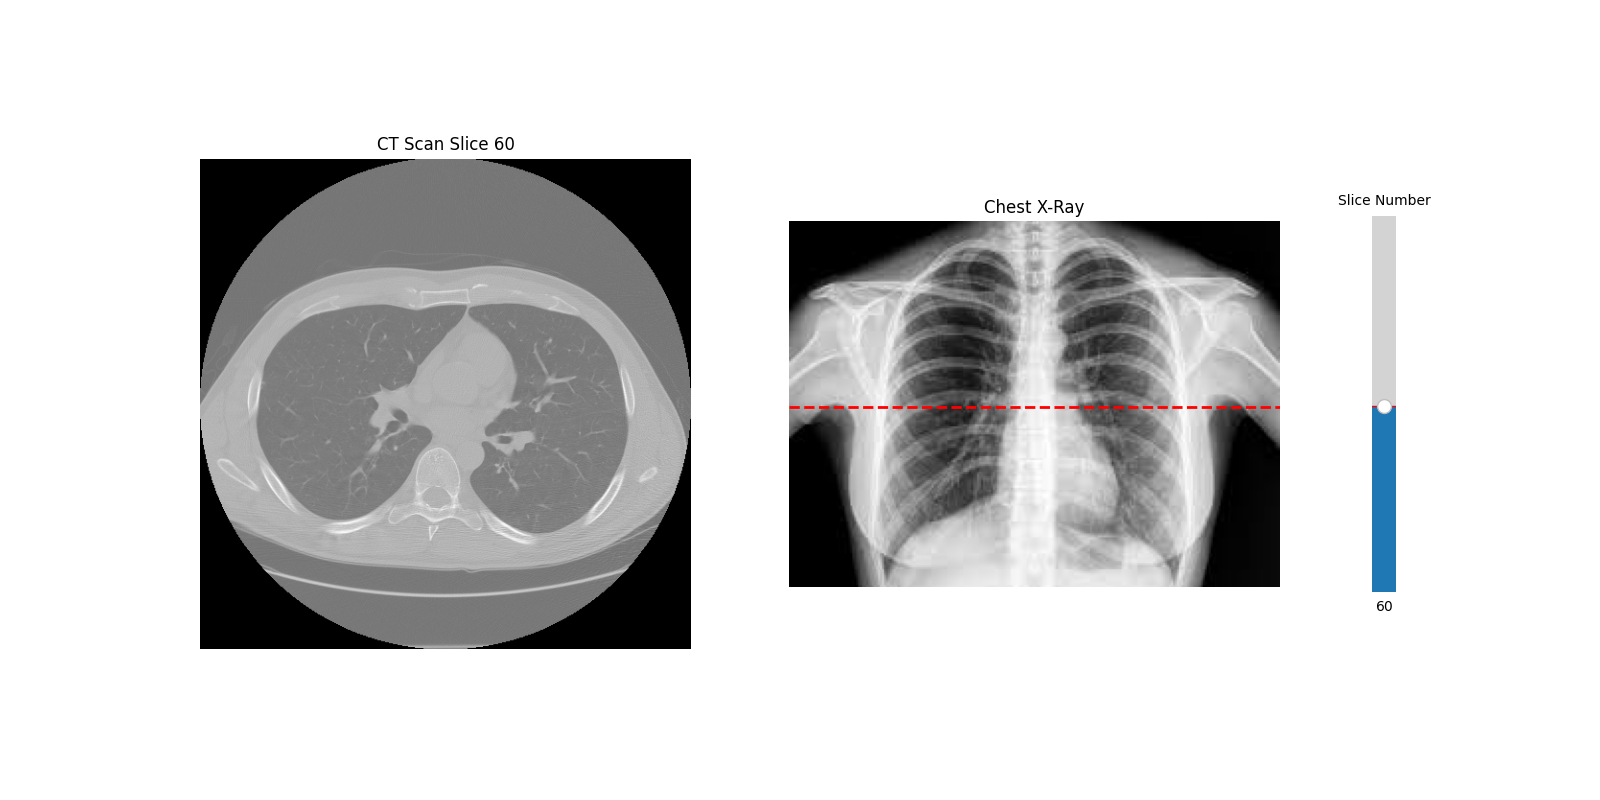

In [120]:
visualize_single_slice(Data["subset0"]["CT_0"])